<a href="https://www.kaggle.com/code/jaswanthkrishnaeaga/wall-crack-classification?scriptVersionId=146222453" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="D90rVo7ahGyBHqpqtBIH")
project = rf.workspace("indian-institute-of-information-technology-sricity").project("wall-crack-detection-own")
dataset = project.version(3).download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to wall-crack-detection-own-3 in folder:: 100%|██████████| 322/322 [00:00<00:00, 4612.84it/s]


In [2]:
import os
def walkthrough_dir(dir_path):
  for dpath, dname, filename in os.walk(dir_path):
    print(f'There are {len(dname)} directories and {len(filename)} files in {dpath}.')

In [3]:
train_dir = '/kaggle/working/wall-crack-detection-own-3/train'
valid_dir = '/kaggle/working/wall-crack-detection-own-3/valid'
test_dir = '/kaggle/working/wall-crack-detection-own-3/test'

In [4]:
walkthrough_dir('/kaggle/working/wall-crack-detection-own-3')

There are 3 directories and 2 files in /kaggle/working/wall-crack-detection-own-3.
There are 3 directories and 0 files in /kaggle/working/wall-crack-detection-own-3/test.
There are 0 directories and 14 files in /kaggle/working/wall-crack-detection-own-3/test/crack.
There are 0 directories and 16 files in /kaggle/working/wall-crack-detection-own-3/test/Scratched Paint.
There are 0 directories and 13 files in /kaggle/working/wall-crack-detection-own-3/test/no crack.
There are 3 directories and 0 files in /kaggle/working/wall-crack-detection-own-3/valid.
There are 0 directories and 16 files in /kaggle/working/wall-crack-detection-own-3/valid/crack.
There are 0 directories and 17 files in /kaggle/working/wall-crack-detection-own-3/valid/Scratched Paint.
There are 0 directories and 10 files in /kaggle/working/wall-crack-detection-own-3/valid/no crack.
There are 3 directories and 0 files in /kaggle/working/wall-crack-detection-own-3/train.
There are 0 directories and 114 files in /kaggle/wor

# **Getting Data Ready**

In [5]:
import tensorflow as tf
IMG_SIZE = (640,640)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE)
valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                 label_mode='categorical',
                                                                 image_size=IMG_SIZE,
                                                                 shuffle=False)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 222 files belonging to 3 classes.
Found 43 files belonging to 3 classes.
Found 43 files belonging to 3 classes.


# **Checkpoint**
---
A **checkpoint** is an intermediate dump of a model's entire internal state (its weights, current learning rate, etc.) so that the framework can resume the training from this point whenever desired.

In [6]:
checkpoint_path = 'fruits_classification_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                         save_best_only=True)

# **Data Augmentation**
---
**Data augmentation** is the process of transforming images to create new ones, for training machine learning models.

In [7]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1/255.)
],name='data_augmenation')

# **Model Building**
---
We will be using the Keras **Functional API** which is a way to create models that are more flexible than the **tf.keras.Sequential API**. The functional API can handle models with non-linear topology, shared layers, and even multiple inputs or outputs.

The main idea is that a deep learning model is usually a **directed acyclic graph (DAG)** of layers. So the functional API is a way to build graphs of layers.

We will be using 2 pretrained models here. So basically this will be **Transfer Learning**.The reuse of a pre-trained model on a new problem is known as transfer learning in machine learning. A machine uses the knowledge learned from a prior assignment to increase prediction about a new task in transfer learning.
# MobileNetV2

In [8]:
base_model_1 = tf.keras.applications.MobileNetV2(include_top=False)
base_model_1.trainable = False

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model_1(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
mobilenet_model = tf.keras.Model(inputs, outputs)

9406464/9406464 [==============================] - 0s 0us/step


In [9]:
mobilenet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 640, 640, 3)]     0         
                                                                 
 data_augmenation (Sequentia  (None, None, None, 3)    0         
 l)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                             

In [10]:
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
mobilenet_model_hist = mobilenet_model.fit(train_data,
                 epochs=10,
                 validation_data=valid_data,
                 #validation_steps=int(0.15 * len(valid_data)),
                 callbacks=[checkpoint_callback])

Epoch 1/10
7/7 [==============================] - 34s 3s/step - loss: 1.0404 - accuracy: 0.4685 - val_loss: 0.8852 - val_accuracy: 0.5581
Epoch 2/10
7/7 [==============================] - 20s 3s/step - loss: 0.7282 - accuracy: 0.6622 - val_loss: 0.4774 - val_accuracy: 0.8605
Epoch 3/10
7/7 [==============================] - 18s 3s/step - loss: 0.5226 - accuracy: 0.8829 - val_loss: 0.3266 - val_accuracy: 0.9302
Epoch 4/10
7/7 [==============================] - 21s 3s/step - loss: 0.4269 - accuracy: 0.8919 - val_loss: 0.2428 - val_accuracy: 0.9767
Epoch 5/10
7/7 [==============================] - 16s 2s/step - loss: 0.3194 - accuracy: 0.9550 - val_loss: 0.1815 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 17s 2s/step - loss: 0.2904 - accuracy: 0.9640 - val_loss: 0.1474 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 21s 3s/step - loss: 0.2331 - accuracy: 0.9775 - val_loss: 0.1252 - val_accuracy: 1.0000
Epoch 8/10
7/7 [==================

In [11]:
mobilenet_model_loss, mobilenet_model_acc = mobilenet_model.evaluate(test_data)

2/2 [==============================] - 1s 117ms/step - loss: 0.0948 - accuracy: 1.0000


In [12]:
# Specify the file path where you want to save your model
model_save_path = '/kaggle/working/models/mobilenet_model.h5'

# Save the model to the specified file
mobilenet_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/models/mobilenet_model.h5


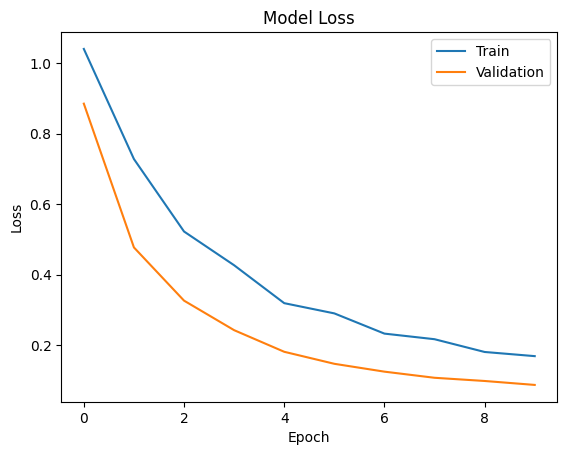

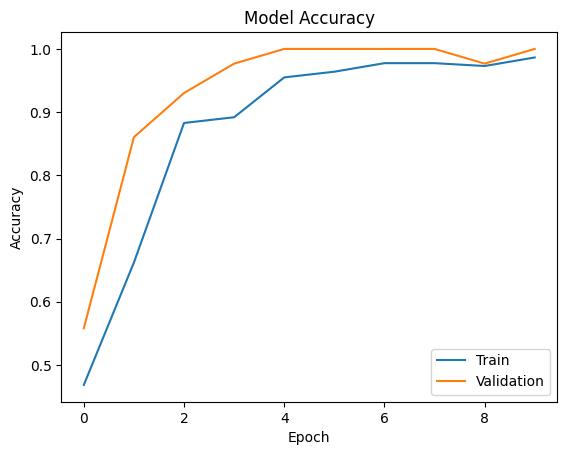

In [14]:
import matplotlib.pyplot as plt

# Assuming you have already trained your model and saved the training history in mobilenet_model_hist.

# Plot training & validation loss values
plt.plot(mobilenet_model_hist.history['loss'])
plt.plot(mobilenet_model_hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.plot(mobilenet_model_hist.history['accuracy'])
plt.plot(mobilenet_model_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

2/2 [==============================] - 1s 311ms/step


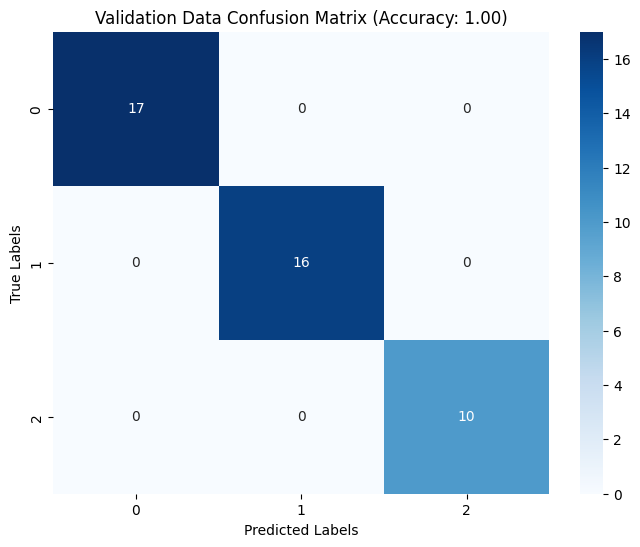

2/2 [==============================] - 1s 263ms/step


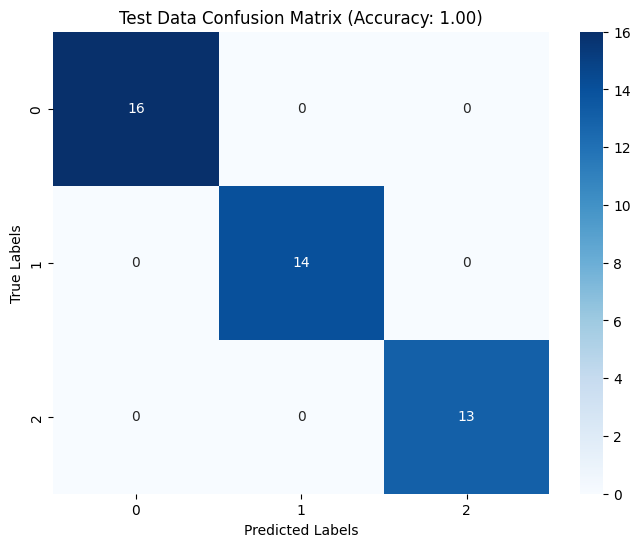

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def save_confusion_matrix(model, data, title, filename):
    predictions = model.predict(data)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Assuming data is a tf.data.Dataset, extract labels
    labels = np.concatenate([y for x, y in data], axis=0)
    true_labels = np.argmax(labels, axis=1)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)
    
    num_classes = len(cm)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{title} (Accuracy: {accuracy:.2f})')
    plt.savefig(filename)
    plt.show()

# Save confusion matrices for train, validation, and test data
# save_confusion_matrix(mobilenet_model, train_data, "Train Data Confusion Matrix", "train_confusion_matrix.png")
save_confusion_matrix(mobilenet_model, valid_data, "Validation Data Confusion Matrix", "valid_confusion_matrix.png")
save_confusion_matrix(mobilenet_model, test_data, "Test Data Confusion Matrix", "test_confusion_matrix.png")


In [30]:
class_names = ["Scratched paint", "crack", "no crack"]
def display_images_with_labels(test_data, model, class_names, n):
    """
    Display 'n' images from the test dataset along with their actual and predicted labels.

    Args:
    test_data (tf.data.Dataset): The test dataset.
    model (tf.keras.Model): The trained model for making predictions.
    class_names (list): List of label names.
    n (int): The number of images to display.
    """
    count = 0
    
    for images, labels in test_data:
        predictions = model.predict(images)
        for i in range(len(images)):
            if count < n:
                actual_label_idx = tf.argmax(labels[i]).numpy() 
                predicted_label_idx = tf.argmax(predictions[i]).numpy() 
                actual_label = class_names[actual_label_idx]
                predicted_label = class_names[predicted_label_idx] 
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}")
                plt.show()

                count += 1  

            else:
                return 

1/1 [==============================] - 0s 206ms/step


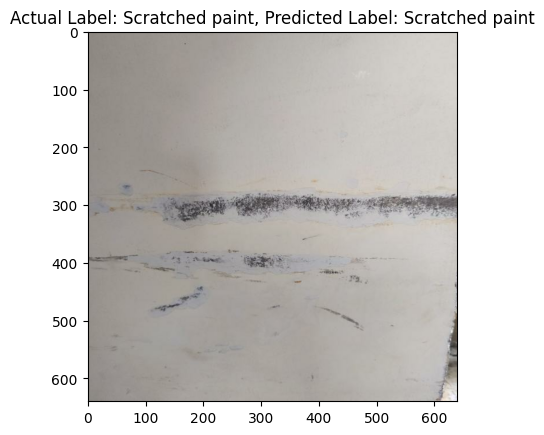

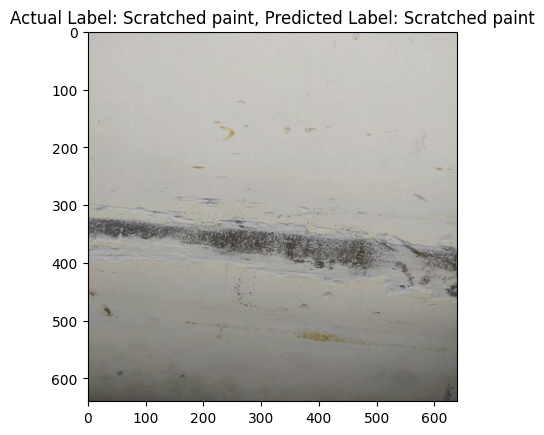

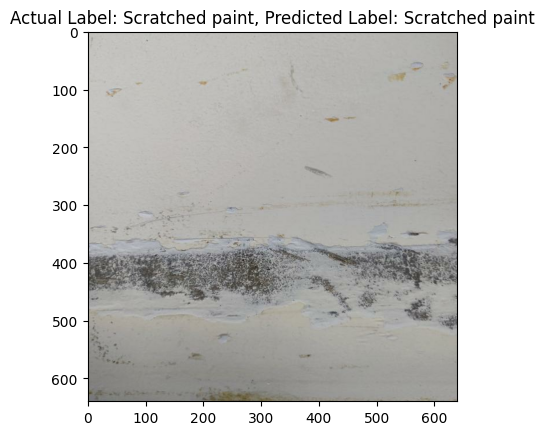

In [32]:
display_images_with_labels(test_data, mobilenet_model, class_names, n=3)

In [33]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

actual_labels = []
predicted_labels = []

for images, labels in test_data:
    predictions = mobilenet_model.predict(images)
    for i in range(len(images)):
        actual_label_idx = tf.argmax(labels[i]).numpy()
        predicted_label_idx = tf.argmax(predictions[i]).numpy()
        actual_labels.append(actual_label_idx)
        predicted_labels.append(predicted_label_idx)

actual_labels = np.array(actual_labels)
predicted_labels = np.array(predicted_labels)

accuracy = accuracy_score(actual_labels, predicted_labels)

precision = precision_score(actual_labels, predicted_labels, average='weighted')
recall = recall_score(actual_labels, predicted_labels, average='weighted')
f1 = f1_score(actual_labels, predicted_labels, average='weighted')

class_report = classification_report(actual_labels, predicted_labels, target_names=class_names)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("Classification Report:")
print(class_report)


1/1 [==============================] - 0s 84ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Classification Report:
                 precision    recall  f1-score   support

Scratched paint       1.00      1.00      1.00        16
          crack       1.00      1.00      1.00        14
       no crack       1.00      1.00      1.00        13

       accuracy                           1.00        43
      macro avg       1.00      1.00      1.00        43
   weighted avg       1.00      1.00      1.00        43

